# Fitting a model's parameters with run-at-a-time optimization

In this notebook, we'll fit a simple compartmental model to disease propagation data. We'll use a standard optimizer built into the python `scipy` library to set two independent parameters to minimize the sum of squared errors between the model's timeseries output and data from the World Health Organization.

## About this technique
A run-at-a-time optimization runs the simulation forward from a single starting point, and so only requires an *a-priori* full state estimate for this initial condition. This makes it especially appropriate when we only have partial information about the state of the system. 

## Ingredients:

We'll use the familiar `pandas` library along with `pysd`, and introduce the optimization functionality provided by `scipy.optimize`.

In [1]:
%pylab inline
import pandas as pd
import pysd
import scipy.optimize

Populating the interactive namespace from numpy and matplotlib


The model that we'll try to fit is simple 'Susceptible-Infectious' model. This model assumes that everyone is either susceptible, or infectious. It assumes that there is no recovery, or death; and doesn't account for changes in behavior due to the presence of the disease. But it is super simple, and Çso we'll accept those limitations for now, until we've seen it's fit to the data.

<img src="../../../source/models/Epidemic/SI_Model.png" alt="Stock and Flow diagram of Susceptible-Infectious model" style="width: 600px;"/>

We'll hold **infectivity** constant, and try to infer values for the **total population** and the **contact frequency**.

In [2]:
model = pysd.read_vensim('../../models/Epidemic/SI_Model.mdl')

We'll fit our model to data from the WHO patient database for Sierra Leone. We see the standard *S-Shaped* growth in the cumulative infections curve. As our model has no structure for representing recovery or death, we will compare this directly to the **Population Infected with Ebola**. We format this dataset in the notebook [Ebola Data Loader](https://pysd-cookbook.readthedocs.io/en/latest/data/Ebola/Ebola_Data_Loader.html).

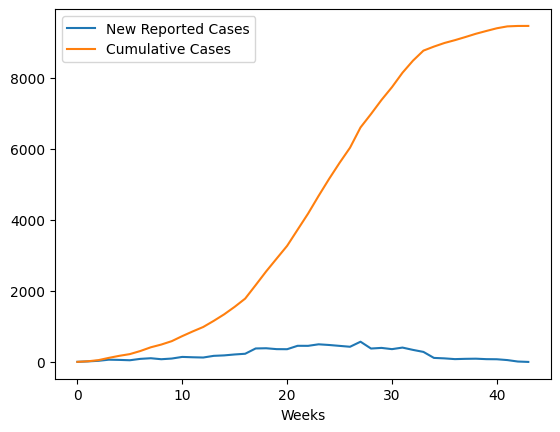

In [3]:
data = pd.read_csv('../../data/Ebola/Ebola_in_SL_Data.csv', index_col='Weeks')
data.plot();

## Recipe

#### Step 1: Construct an 'error' function
We'll begin by constructing a function which takes the model parameters that we intend to vary, and returns the sum of the squared error between the model's prediction and the reported data.

Our optimizer will interact with our parameter set through an ordered list of values, so our function will need to take this list and unpack it before we can pass it into our model.

With `pysd` we can ask directly for the model components that we're interested in, at the timestamps that match our data.

In [4]:
def error(param_list):
    #unpack the parameter list 
    population, contact_frequency = param_list
    #run the model with the new parameters, returning the info we're interested in
    result = model.run(params={'total_population':population,
                               'contact_frequency':contact_frequency},
                       return_columns=['population_infected_with_ebola'],
                       return_timestamps=list(data.index.values))
    #return the sum of the squared errors
    return sum((result['population_infected_with_ebola'] - data['Cumulative Cases'])**2)

error([10000, 10])

157977495.47574666

#### Step 2: Suggest a starting point and parameter bounds for the optimizer
The optimizer will want a starting point from which it will vary the parameters to minimize the error. We'll take a guess based upon the data and our intuition.

As our model is only valid for positive parameter values, we'll want to specify that fact to the optimizer. We know that there must be at least two people for an infection to take place (one person susceptible, and another contageous) and we know that the contact frequency must be a finite, positive value. We can use these, plus some reasonable upper limits, to set the bounds.

In [5]:
susceptible_population_guess = 9000
contact_frequency_guess = 20

susceptible_population_bounds = (2, 50000)
contact_frequency_bounds = (0.001, 100)

#### Step 3: Minimize the error with an optimization function
We pass this function into the optimization function, along with an initial guess as to the parameters that we're optimizing. There are a number of optimization algorithms, each with their own settings, that are available to us through this interface. In this case, we're using the L-BFGS-B algorithm, as it gives us the ability to constrain the values the optimizer will try.

In [6]:
res = scipy.optimize.minimize(error, [susceptible_population_guess,
                                      contact_frequency_guess],
                              method='L-BFGS-B',
                              bounds=[susceptible_population_bounds,
                                      contact_frequency_bounds])
res

      fun: 22200248.07232056
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.60749363e+00, 3.06777631e+03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 93
      nit: 10
     njev: 31
   status: 0
  success: True
        x: array([8.82124175e+03, 8.20469365e+00])

#### Result
If we run the simulation with the parameters suggested by the optimizer, we see that the model follows the general behavior of the data, but is too simple to truly capture the correct shape of the curve.

Text(2, 9000, 'RMSE: 7.5% of Max')

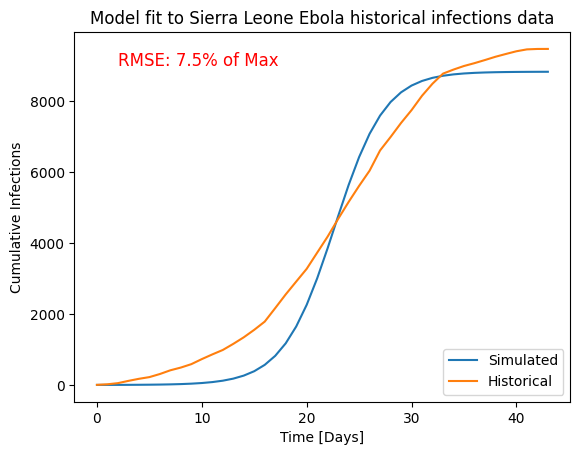

In [7]:
population, contact_frequency = res.x
result = model.run(params={'total_population':population,
                           'contact_frequency':contact_frequency},
                   return_columns=['population_infected_with_ebola'],
                   return_timestamps=list(data.index.values))

plt.plot(result.index, result['population_infected_with_ebola'], label='Simulated')
plt.plot(data.index, data['Cumulative Cases'], label='Historical');
plt.xlabel('Time [Days]')
plt.ylabel('Cumulative Infections')
plt.title('Model fit to Sierra Leone Ebola historical infections data')
plt.legend(loc='lower right')
plt.text(2,9000, 'RMSE: 7.5% of Max', color='r', fontsize=12)

In [8]:
res

      fun: 22200248.07232056
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.60749363e+00, 3.06777631e+03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 93
      nit: 10
     njev: 31
   status: 0
  success: True
        x: array([8.82124175e+03, 8.20469365e+00])

In [9]:
sqrt(res.fun/len(data))/data['Cumulative Cases'].max()

0.07505469143880455